This is data mining code for the HAP780 final project after exporting the datasets from All of Us

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Load the datasets
df_analysis = pd.read_csv('./data/df_analysis_final.csv')

Feature Creation: Age as dummy variables in decades

In [3]:
# Define bins
bins = [0, 18, 28, 38, 48, 58, 68, 78, 88, 98, float('inf')]
labels = ['<18', '18-27', '28-37', '38-47', '48-57', '58-67', '68-77', '78-87', '88-97', '98+']

# Cut the age_at_first_diagnosis into bins
df_analysis['age_group'] = pd.cut(df_analysis['age_at_first_diagnosis'], bins=bins, labels=labels, right=False)

# Convert the binned data into dummy variables
age_dummies = pd.get_dummies(df_analysis['age_group'])

# Concatenate the dummy variables with the original dataframe if needed
df_analysis = pd.concat([df_analysis, age_dummies], axis=1)

# Drop the 'age_at_first_diagnosis' and 'age_group' columns from the dataframe
df_analysis = df_analysis.drop(['age_at_first_diagnosis', 'age_group'], axis=1)

In [4]:
df_analysis.head()

,race_Another single population,race_Asian,race_Black or African American,race_I prefer not to answer,race_More than one population,race_None Indicated,race_None of these,race_PMI: Skip,race_White,ethnicity_Hispanic or Latino,...,<18,18-27,28-37,38-47,48-57,58-67,68-77,78-87,88-97,98+
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


Feature Creation: Create Interaction Variables (2-way only due to memory constraints)

In [5]:
# Import library
from sklearn.preprocessing import PolynomialFeatures

In [6]:
# Drop the target variable
X = df_analysis.drop(columns=['No_remission'])

# Create polynomial features (interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Create a dataframe for the interaction terms
df_interactions = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

# Identify interaction terms only (exclude original feature columns)
interaction_columns = df_interactions.columns[~df_interactions.columns.isin(X.columns)]

# Join the original df_analysis with the interaction terms dataframe
df_analysis_extended = pd.concat([df_analysis, df_interactions[interaction_columns]], axis=1)

Data cleaning: Remove columns that have all zeroes or all ones

In [7]:
# Get all columns that are all ones or all zeroes for dropping
columns_to_drop = df_analysis_extended.columns[(
    df_analysis_extended.sum(axis=0) == len(df_analysis_extended)) | (df_analysis_extended.sum(axis=0) == 0)]

# Drop these columns
df_analysis_extended = df_analysis_extended.drop(columns=columns_to_drop)

In [8]:
df_analysis_extended.head()

,race_Another single population,race_Asian,race_Black or African American,race_I prefer not to answer,race_More than one population,race_None Indicated,race_None of these,race_PMI: Skip,race_White,ethnicity_Hispanic or Latino,...,no_food_Often true 38-47,no_food_Often true 48-57,no_food_Often true 58-67,no_food_PMI: Skip 38-47,no_food_PMI: Skip 48-57,no_food_Sometimes true 28-37,no_food_Sometimes true 38-47,no_food_Sometimes true 48-57,no_food_Sometimes true 58-67,no_food_Sometimes true 68-77
0,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_analysis_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Columns: 15239 entries, race_Another single population to no_food_Sometimes true 68-77
dtypes: float64(14986), int64(246), uint8(7)
memory usage: 188.4 MB


Split the data into Training (80%) and Test (20%)

In [10]:
# Import library
from sklearn.model_selection import train_test_split

In [11]:
# Splitting the data into training and test sets
train_set, test_set = train_test_split(df_analysis_extended, test_size=0.20, random_state=42)

In [12]:
train_set.head()

,race_Another single population,race_Asian,race_Black or African American,race_I prefer not to answer,race_More than one population,race_None Indicated,race_None of these,race_PMI: Skip,race_White,ethnicity_Hispanic or Latino,...,no_food_Often true 38-47,no_food_Often true 48-57,no_food_Often true 58-67,no_food_PMI: Skip 38-47,no_food_PMI: Skip 48-57,no_food_Sometimes true 28-37,no_food_Sometimes true 38-47,no_food_Sometimes true 48-57,no_food_Sometimes true 58-67,no_food_Sometimes true 68-77
905,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1088,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1330,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1603,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 905 to 1126
Columns: 15239 entries, race_Another single population to no_food_Sometimes true 68-77
dtypes: float64(14986), int64(246), uint8(7)
memory usage: 150.6 MB


In [14]:
test_set.head()

,race_Another single population,race_Asian,race_Black or African American,race_I prefer not to answer,race_More than one population,race_None Indicated,race_None of these,race_PMI: Skip,race_White,ethnicity_Hispanic or Latino,...,no_food_Often true 38-47,no_food_Often true 48-57,no_food_Often true 58-67,no_food_PMI: Skip 38-47,no_food_PMI: Skip 48-57,no_food_Sometimes true 28-37,no_food_Sometimes true 38-47,no_food_Sometimes true 48-57,no_food_Sometimes true 58-67,no_food_Sometimes true 68-77
135,0,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1233,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1214,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
628,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 135 to 707
Columns: 15239 entries, race_Another single population to no_food_Sometimes true 68-77
dtypes: float64(14986), int64(246), uint8(7)
memory usage: 37.8 MB


In [16]:
# Write train and test sets to a file for reference
train_set.to_csv("./data/train.csv", index=False)
test_set.to_csv("./data/test.csv", index=False)

Baseline models without feature selection

In [17]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             matthews_corrcoef, 
                             roc_auc_score, 
                             average_precision_score)

In [18]:
# Splitting the data into features and target
X_train = train_set.drop(columns=['No_remission'])
y_train = train_set['No_remission']


# Splitting the test data into features and target
X_test = test_set.drop(columns=['No_remission'])
y_test = test_set['No_remission']

Feature Selection: LASSO Regression with Cross-Validation

In [19]:
# Import library
from sklearn.linear_model import LassoCV

In [20]:
# Initializing LassoCV (5 folds)
lasso_cv = LassoCV(cv=5, random_state=42)

# Fitting the model
lasso_cv.fit(X_train, y_train)

# Get the feature coefficients
coef = pd.Series(lasso_cv.coef_, index=X_train.columns)

# Filter out the features which have a coefficient of zero
selected_features_lasso = coef[coef != 0].index.tolist()

c:\Users\vladc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.340e-02, tolerance: 2.015e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\vladc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e-02, tolerance: 2.015e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\vladc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [21]:
# Print selected feature and direction
print(f"Number of features selected: {len(selected_features_lasso)}\n")

for feature, coef in zip(selected_features_lasso, lasso_cv.coef_):
    effect = 'increase' if coef > 0 else 'decrease' if coef < 0 else 'no effect'
    print(f"feature: '{feature}' | effect: {effect}")

Number of features selected: 27

feature: 'race_White disease_group_363171009' | effect: no effect
feature: 'race_White disease_group_400096001' | effect: no effect
feature: 'ethnicity_Not Hispanic or Latino disease_group_2492009' | effect: no effect
feature: 'ethnicity_Not Hispanic or Latino disease_group_49601007' | effect: no effect
feature: 'ethnicity_Not Hispanic or Latino disease_group_197480006' | effect: no effect
feature: 'ethnicity_Not Hispanic or Latino near_transit_Strongly agree' | effect: no effect
feature: 'disease_group_928000 disease_group_2492009' | effect: no effect
feature: 'disease_group_928000 disease_group_3723001' | effect: no effect
feature: 'disease_group_928000 disease_group_32895009' | effect: no effect
feature: 'disease_group_928000 disease_group_42030000' | effect: no effect
feature: 'disease_group_928000 disease_group_49601007' | effect: no effect
feature: 'disease_group_928000 disease_group_53619000' | effect: no effect
feature: 'disease_group_928000 dis

In [22]:
# Filter train and test sets for selected features
X_train_selected_lasso = X_train[selected_features_lasso]
X_test_selected_lasso = X_test[selected_features_lasso]

Class Balancing Using Synthetic Minority Over-sampling Technique (SMOTE)

In [23]:
# Import libraries
from imblearn.over_sampling import SMOTE

In [24]:
# Using SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Resampled sample size
print(f"Original training sample size: {X_train.shape[0]}")
print(f"Resampled training sample size: {X_resampled.shape[0]}")

Original training sample size: 1296
Resampled training sample size: 1910


Model Training and Testing Using Balanced Data and Selected Features (LASSO)

In [25]:
# Filter train and test sets for selected features
X_train_selected_lasso_2 = X_resampled[selected_features_lasso]
X_test_selected_lasso_2 = X_test[selected_features_lasso]

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# Metrics collection
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train_selected_lasso_2, y_resampled)
    
    # Predict
    y_pred = model.predict(X_test_selected_lasso_2)
    
    # Metrics
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    fmeasure = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_area = roc_auc_score(y_test, model.predict_proba(X_test_selected_lasso_2)[:, 1])
    prc_area = average_precision_score(y_test, model.predict_proba(X_test_selected_lasso_2)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression
Confusion Matrix: [[171  66]
 [ 34  54]]
Precision: 0.45
Recall: 0.6136363636363636
F-Measure: 0.5192307692307692
MCC: 0.30859871484230766
ROC Area: 0.7026035673187572
PRC Area: 0.5245184869388095


Model: Random Forest
Confusion Matrix: [[210  27]
 [ 56  32]]
Precision: 0.5423728813559322
Recall: 0.36363636363636365
F-Measure: 0.43537414965986393
MCC: 0.28786485275186363
ROC Area: 0.656765439202148
PRC Area: 0.46973764464876344


Model: Naive Bayes
Confusion Matrix: [[173  64]
 [ 36  52]]
Precision: 0.4482758620689655
Recall: 0.5909090909090909
F-Measure: 0.5098039215686274
MCC: 0.29760367204586136
ROC Area: 0.6856779823551975
PRC Area: 0.48726174993367427


Model: XGBoost
Confusion Matrix: [[212  25]
 [ 58  30]]
Precision: 0.5454545454545454
Recall: 0.3409090909090909
F-Measure: 0.41958041958041953
MCC: 0.2789990703811504
ROC Area: 0.6304420790180284
PRC Area: 0.4712476562684005




Hyperparameter Tuning Of Unbalanced Data Models
- Scoring will be based on recall

In [26]:
# Import library
from sklearn.model_selection import GridSearchCV

In [27]:
# Logistic Regression

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Initialize the GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), 
                              param_grid=param_grid_lr, 
                              scoring=['recall'], 
                              refit='recall', 
                              cv=5)

# Fit the grid search to the data
grid_search_lr.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_lr.best_params_)

# Predict
best_estimator = grid_search_lr.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_logreg = best_estimator

Best parameters set found on training set:
{'C': 10, 'penalty': 'l1'}
Confusion Matrix: [[221  16]
 [ 58  30]]
Precision: 0.6521739130434783
Recall: 0.3409090909090909
F-Measure: 0.44776119402985076
MCC: 0.34852239229471765
ROC Area: 0.7010692366705025
PRC Area: 0.5249175000279894


In [28]:
# Random Forest

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                              param_grid=param_grid_rf, 
                              scoring=['recall'], 
                              refit='recall', 
                              cv=5)

# Fit the grid search to the data
grid_search_rf.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_rf.best_params_)

# Predict
best_estimator = grid_search_rf.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_rf = best_estimator

Best parameters set found on training set:
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix: [[213  24]
 [ 61  27]]
Precision: 0.5294117647058824
Recall: 0.3068181818181818
F-Measure: 0.38848920863309355
MCC: 0.25111786189395513
ROC Area: 0.6614163789796701
PRC Area: 0.4788452793296756


In [29]:
# Naive Bayes

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for GaussianNB
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Initialize the GridSearchCV object for GaussianNB
grid_search_gnb = GridSearchCV(estimator=GaussianNB(), 
                               param_grid=param_grid_gnb, 
                               scoring=['recall'], 
                               refit='recall', 
                               cv=5)

# Fit the grid search to the data
grid_search_gnb.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_gnb.best_params_)

# Predict
best_estimator = grid_search_gnb.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_nb = best_estimator

Best parameters set found on training set:
{'var_smoothing': 0.008111308307896872}
Confusion Matrix: [[185  52]
 [ 41  47]]
Precision: 0.47474747474747475
Recall: 0.5340909090909091
F-Measure: 0.5026737967914439
MCC: 0.30381910378282784
ROC Area: 0.692150939777522
PRC Area: 0.48580411161330267


In [30]:
# XGBoost

# Define training sets as unbalanced with feature selection (X_train_selected_lasso, y_train)
# Define test set as balanced with feature selection (X_test_selected_lasso, y_test)

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7, 1]
}

# Initialize the GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                               param_grid=param_grid_xgb, 
                               scoring=['recall'], 
                               refit='recall', 
                               cv=5)

# Fit the grid search to the data
grid_search_xgb.fit(X_train_selected_lasso, y_train)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_xgb.best_params_)

# Predict
best_estimator = grid_search_xgb.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
unbal_xgb = best_estimator

Best parameters set found on training set:
{'colsample_bytree': 1, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 200}
Confusion Matrix: [[203  34]
 [ 56  32]]
Precision: 0.48484848484848486
Recall: 0.36363636363636365
F-Measure: 0.4155844155844156
MCC: 0.2432005319324558
ROC Area: 0.625071921749137
PRC Area: 0.4615430718655136


Hyperparameter Tuning Of Best Data and Feature Combination On Recall
- Scoring will be based on recall
- Chosen training set with highest recall: Balanced with Feature Selection 

In [31]:
# Logistic Regression

# Define training sets as balanced with feature selection (X_train_selected_lasso_2, y_resampled)
# Define test set as balanced with feature selection (X_test_selected_lasso_2)

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Initialize the GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), 
                              param_grid=param_grid_lr, 
                              scoring=['recall'], 
                              refit='recall', 
                              cv=5)

# Fit the grid search to the data
grid_search_lr.fit(X_train_selected_lasso_2, y_resampled)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_lr.best_params_)

# Predict
best_estimator = grid_search_lr.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso_2)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
best_logreg = best_estimator

Best parameters set found on training set:
{'C': 0.001, 'penalty': 'l2'}
Confusion Matrix: [[ 91 146]
 [ 14  74]]
Precision: 0.33636363636363636
Recall: 0.8409090909090909
F-Measure: 0.48051948051948057
MCC: 0.21367383447203006
ROC Area: 0.6899932873034139
PRC Area: 0.47985160730207554


In [32]:
# Random Forest

# Define training sets as balanced with feature selection (X_train_selected_lasso_2, y_resampled)
# Define test set as balanced with feature selection (X_test_selected_lasso_2)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                              param_grid=param_grid_rf, 
                              scoring=['recall'], 
                              refit='recall', 
                              cv=5)

# Fit the grid search to the data
grid_search_rf.fit(X_train_selected_lasso_2, y_resampled)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_rf.best_params_)

# Predict
best_estimator = grid_search_rf.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso_2)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
best_rf = best_estimator

Best parameters set found on training set:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Confusion Matrix: [[213  24]
 [ 51  37]]
Precision: 0.6065573770491803
Recall: 0.42045454545454547
F-Measure: 0.4966442953020135
MCC: 0.36324209092251586
ROC Area: 0.6833285385500575
PRC Area: 0.5291500119971921


In [33]:
# Naive Bayes

# Define training sets as balanced with feature selection (X_train_selected_lasso_2, y_resampled)
# Define test set as balanced with feature selection (X_test_selected_lasso_2)

# Define the parameter grid for GaussianNB
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Initialize the GridSearchCV object for GaussianNB
grid_search_gnb = GridSearchCV(estimator=GaussianNB(), 
                               param_grid=param_grid_gnb, 
                               scoring=['recall'], 
                               refit='recall', 
                               cv=5)

# Fit the grid search to the data
grid_search_gnb.fit(X_train_selected_lasso_2, y_resampled)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_gnb.best_params_)

# Predict
best_estimator = grid_search_gnb.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso_2)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
best_nb = best_estimator

Best parameters set found on training set:
{'var_smoothing': 0.02310129700083159}
Confusion Matrix: [[171  66]
 [ 37  51]]
Precision: 0.4358974358974359
Recall: 0.5795454545454546
F-Measure: 0.49756097560975615
MCC: 0.27870860375568157
ROC Area: 0.6873082086689681
PRC Area: 0.4887199910184316


In [34]:
# XGBoost

# Define training sets as balanced with feature selection (X_train_selected_lasso_2, y_resampled)
# Define test set as balanced with feature selection (X_test_selected_lasso_2)

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7, 1]
}

# Initialize the GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                               param_grid=param_grid_xgb, 
                               scoring=['recall'], 
                               refit='recall', 
                               cv=5)

# Fit the grid search to the data
grid_search_xgb.fit(X_train_selected_lasso_2, y_resampled)

# After fitting, we can check the best performance in the training set
print("Best parameters set found on training set:")
print(grid_search_xgb.best_params_)

# Predict
best_estimator = grid_search_xgb.best_estimator_
y_pred = best_estimator.predict(X_test_selected_lasso_2)
    
# Metrics
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fmeasure = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_area = roc_auc_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
prc_area = average_precision_score(y_test, best_estimator.predict_proba(X_test_selected_lasso_2)[:, 1])
    
results = {
    'Confusion Matrix': confusion,
    'Precision': precision,
    'Recall': recall,
    'F-Measure': fmeasure,
    'MCC': mcc,
    'ROC Area': roc_area,
    'PRC Area': prc_area
}
    
# Display results
for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")

# Save best estimator for plotting
best_xgb = best_estimator

Best parameters set found on training set:
{'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 500}
Confusion Matrix: [[203  34]
 [ 55  33]]
Precision: 0.4925373134328358
Recall: 0.375
F-Measure: 0.42580645161290326
MCC: 0.2543281557383259
ROC Area: 0.6233937476026084
PRC Area: 0.4727095175880519


Plotting the ROC curves using specificity and recall

In [35]:
# Import the libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

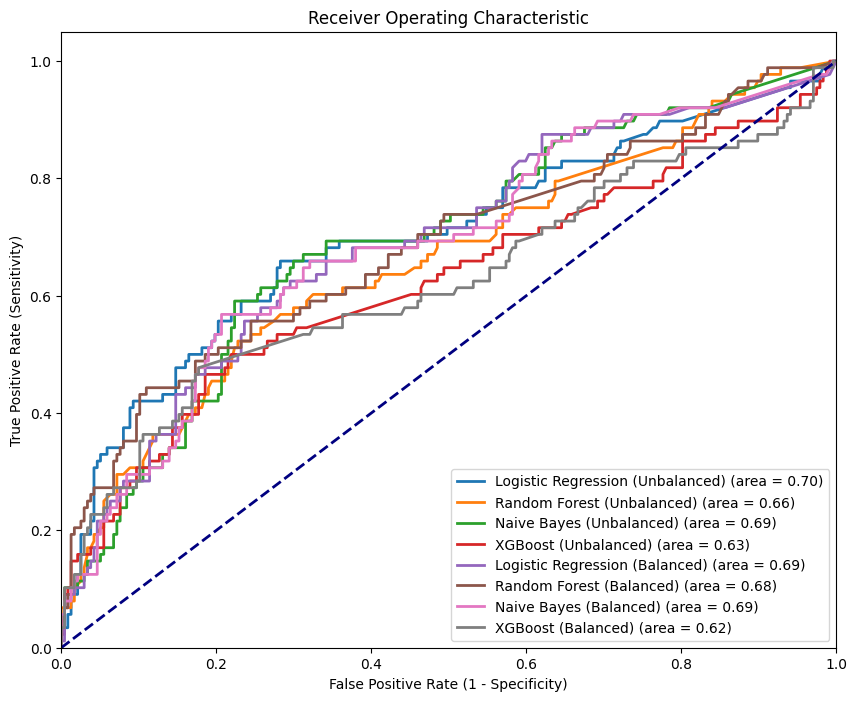

In [36]:
# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb,
    'Logistic Regression (Balanced)': best_logreg,
    'Random Forest (Balanced)': best_rf,
    'Naive Bayes (Balanced)': best_nb,
    'XGBoost (Balanced)': best_xgb
}

plt.figure(figsize=(10, 8))

# Calculate ROC curve and ROC AUC for each model
for name, model in models.items():
    probas_ = model.predict_proba(X_test_selected_lasso_2)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


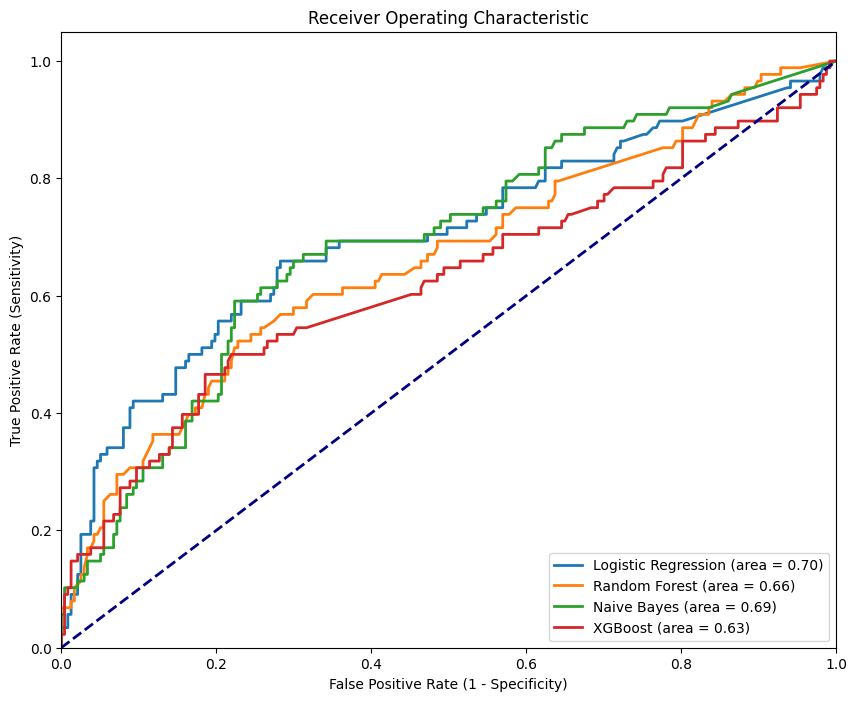

In [37]:
# Define models
models = {
    'Logistic Regression': unbal_logreg,
    'Random Forest': unbal_rf,
    'Naive Bayes': unbal_nb,
    'XGBoost': unbal_xgb,
}

plt.figure(figsize=(10, 8))

# Calculate ROC curve and ROC AUC for each model
for name, model in models.items():
    probas_ = model.predict_proba(X_test_selected_lasso_2)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


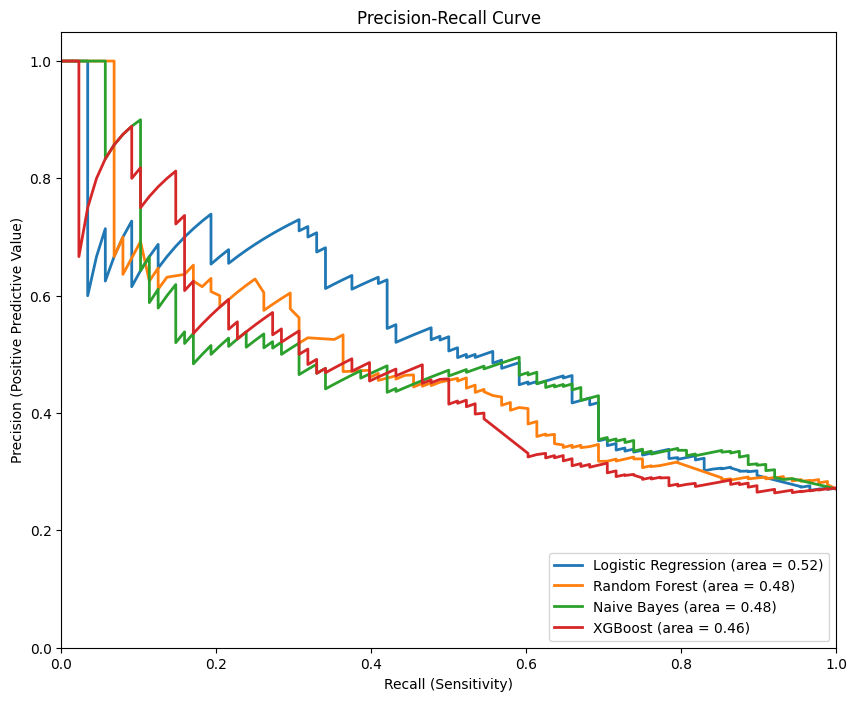

In [38]:
from sklearn.metrics import precision_recall_curve, auc


plt.figure(figsize=(10, 8))

# Calculate precision-recall curve and AUC for each model
for name, model in models.items():
    probas_ = model.predict_proba(X_test_selected_lasso_2)
    precision, recall, thresholds = precision_recall_curve(y_test, probas_[:, 1])
    auprc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (area = {auprc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right") 
plt.show()

Plotting feature impact for best model: Logistic Regression

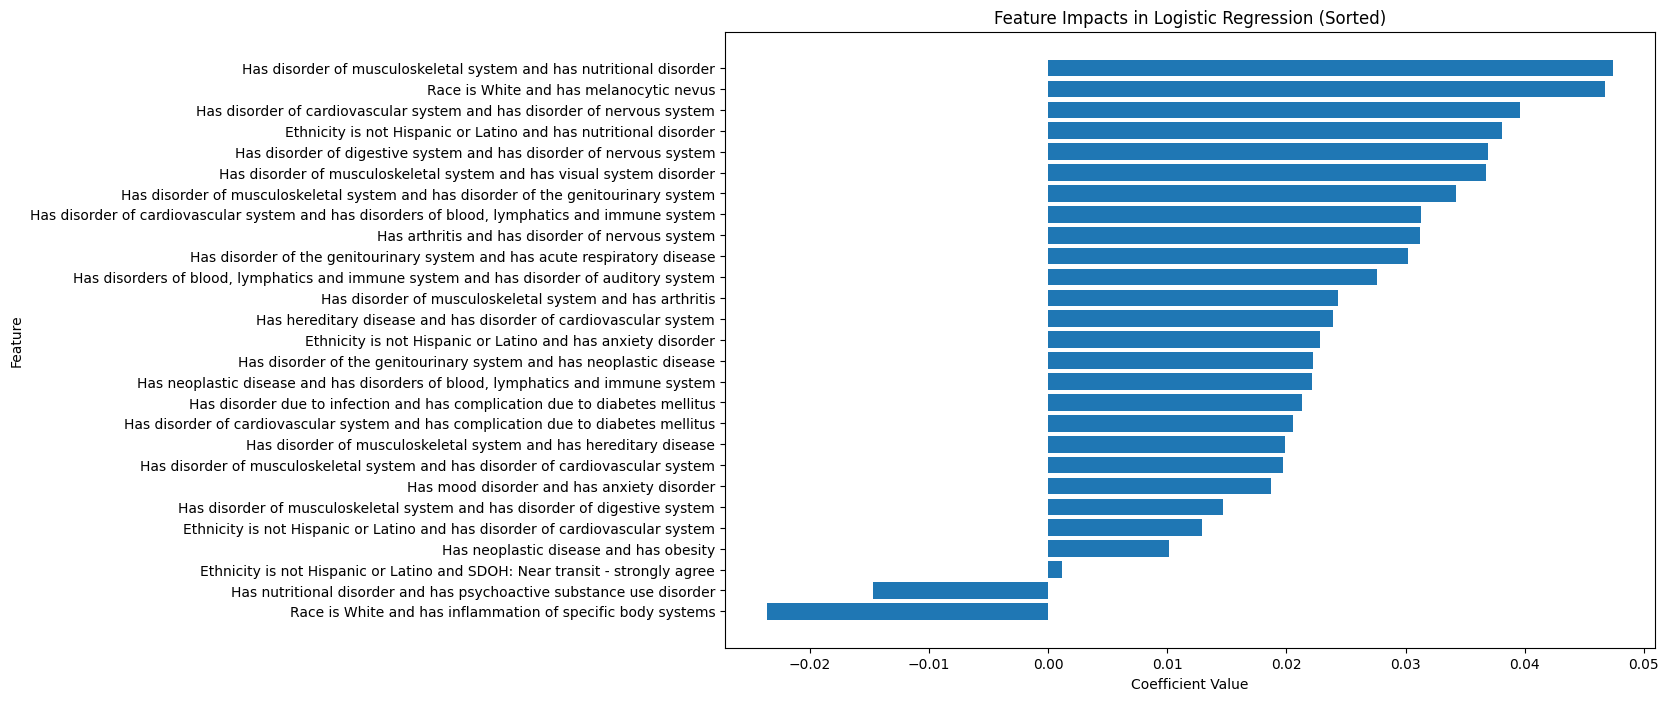

In [40]:
# Get best_model for Logistic Regression model
model_coefs = best_logreg.coef_[0]  # Coefficients for the model
feature_names = X_train_selected_lasso_2.columns  # Feature names

# Create a sorted list of (coefficient, feature) tuples
sorted_features = sorted(zip(model_coefs, feature_names), reverse=True)

# Separate the coefficients and feature names
sorted_coefs, sorted_feature_names = zip(*sorted_features)

# Create a dictionary to map old feature names to new feature names
feature_mapping = {
    'race_White disease_group_363171009' : 'Race is White and has inflammation of specific body systems',
    'race_White disease_group_400096001' : 'Race is White and has melanocytic nevus',
    'ethnicity_Not Hispanic or Latino disease_group_2492009' : 'Ethnicity is not Hispanic or Latino and has nutritional disorder',
    'ethnicity_Not Hispanic or Latino disease_group_49601007' : 'Ethnicity is not Hispanic or Latino and has disorder of cardiovascular system',
    'ethnicity_Not Hispanic or Latino disease_group_197480006' : 'Ethnicity is not Hispanic or Latino and has anxiety disorder',
    'ethnicity_Not Hispanic or Latino near_transit_Strongly agree' : 'Ethnicity is not Hispanic or Latino and SDOH: Near transit - strongly agree',
    'disease_group_928000 disease_group_2492009' : 'Has disorder of musculoskeletal system and has nutritional disorder',
    'disease_group_928000 disease_group_3723001' : 'Has disorder of musculoskeletal system and has arthritis',
    'disease_group_928000 disease_group_32895009' : 'Has disorder of musculoskeletal system and has hereditary disease',
    'disease_group_928000 disease_group_42030000' : 'Has disorder of musculoskeletal system and has disorder of the genitourinary system',
    'disease_group_928000 disease_group_49601007' : 'Has disorder of musculoskeletal system and has disorder of cardiovascular system',
    'disease_group_928000 disease_group_53619000' : 'Has disorder of musculoskeletal system and has disorder of digestive system',
    'disease_group_928000 disease_group_128127008' : 'Has disorder of musculoskeletal system and has visual system disorder',
    'disease_group_2492009 disease_group_11061003' : 'Has nutritional disorder and has psychoactive substance use disorder',
    'disease_group_3723001 disease_group_118940003' : 'Has arthritis and has disorder of nervous system',
    'disease_group_32895009 disease_group_49601007' : 'Has hereditary disease and has disorder of cardiovascular system',
    'disease_group_40733004 disease_group_74627003' : 'Has disorder due to infection and has complication due to diabetes mellitus',
    'disease_group_42030000 disease_group_55342001' : 'Has disorder of the genitourinary system and has neoplastic disease',
    'disease_group_42030000 disease_group_111273006' : 'Has disorder of the genitourinary system and has acute respiratory disease',
    'disease_group_46206005 disease_group_197480006' : 'Has mood disorder and has anxiety disorder',
    'disease_group_49601007 disease_group_74627003' : 'Has disorder of cardiovascular system and has complication due to diabetes mellitus',
    'disease_group_49601007 disease_group_118940003' : 'Has disorder of cardiovascular system and has disorder of nervous system',
    'disease_group_49601007 disease_group_234337006' : 'Has disorder of cardiovascular system and has disorders of blood, lymphatics and immune system',
    'disease_group_53619000 disease_group_118940003' : 'Has disorder of digestive system and has disorder of nervous system',
    'disease_group_55342001 disease_group_234337006' : 'Has neoplastic disease and has disorders of blood, lymphatics and immune system',
    'disease_group_55342001 disease_group_414916001' : 'Has neoplastic disease and has obesity',
    'disease_group_234337006 disease_group_362966006' : 'Has disorders of blood, lymphatics and immune system and has disorder of auditory system'
}

# Replace old feature names with new feature names
sorted_feature_names = [feature_mapping.get(feature, feature) for feature in sorted_feature_names]

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_feature_names)), sorted_coefs)
plt.yticks(np.arange(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Impacts in Logistic Regression (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to show the largest coefficients at the top
plt.show()

Race Mix and Ethnicity Mix Analysis

In [41]:
# Filter test set for particular race or ethnicity

# Non-Hispanic White
test_set_NHWhite = test_set[(test_set['race_White'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)]
X_test_NHWhite = test_set_NHWhite.drop(columns=['No_remission'])
X_test_NHWhite = X_test_NHWhite[selected_features_lasso]
y_test_NHWhite = test_set_NHWhite['No_remission']

# Non-Hispanic Black
test_set_NHBlack = test_set[(test_set['race_Black or African American'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)]
X_test_NHBlack = test_set_NHBlack.drop(columns=['No_remission'])
X_test_NHBlack = X_test_NHBlack[selected_features_lasso]
y_test_NHBlack = test_set_NHBlack['No_remission']

# Hispanic
test_set_Hispanic = test_set[test_set['ethnicity_Hispanic or Latino'] == 1]
X_test_Hispanic = test_set_Hispanic.drop(columns=['No_remission'])
X_test_Hispanic = X_test_Hispanic[selected_features_lasso]
y_test_Hispanic = test_set_Hispanic['No_remission']

# Other
test_set_Other = test_set[~(((test_set['race_White'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)) | 
                            ((test_set['race_Black or African American'] == 1) & (test_set['ethnicity_Not Hispanic or Latino'] == 1)) | 
                            (test_set['ethnicity_Hispanic or Latino'] == 1))]
X_test_Other = test_set_Other.drop(columns=['No_remission'])
X_test_Other = X_test_Other[selected_features_lasso]
y_test_Other = test_set_Other['No_remission']

# Number of selected rows
print(f"""Non-Hispanic White: {test_set_NHWhite.shape[0]} | 
      Non-Hispanic Black: {test_set_NHBlack.shape[0]} | 
      Hispanic: {test_set_Hispanic.shape[0]} | 
      Other: {test_set_Other.shape[0]}""")

Non-Hispanic White: 224 | 
      Non-Hispanic Black: 40 | 
      Hispanic: 38 | 
      Other: 23


In [42]:
# Test models on Non-Hispanic White test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb,
    'Logistic Regression (Balanced)': best_logreg,
    'Random Forest (Balanced)': best_rf,
    'Naive Bayes (Balanced)': best_nb,
    'XGBoost (Balanced)': best_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_NHWhite)
    
    # Metrics
    confusion = confusion_matrix(y_test_NHWhite, y_pred)
    precision = precision_score(y_test_NHWhite, y_pred)
    recall = recall_score(y_test_NHWhite, y_pred)
    fmeasure = f1_score(y_test_NHWhite, y_pred)
    mcc = matthews_corrcoef(y_test_NHWhite, y_pred)
    roc_area = roc_auc_score(y_test_NHWhite, model.predict_proba(X_test_NHWhite)[:, 1])
    prc_area = average_precision_score(y_test_NHWhite, model.predict_proba(X_test_NHWhite)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[143  15]
 [ 44  22]]
Precision: 0.5945945945945946
Recall: 0.3333333333333333
F-Measure: 0.42718446601941745
MCC: 0.29267049881338975
ROC Area: 0.6888185654008439
PRC Area: 0.5254574984135567


Model: Random Forest (Unbalanced)
Confusion Matrix: [[137  21]
 [ 47  19]]
Precision: 0.475
Recall: 0.2878787878787879
F-Measure: 0.3584905660377358
MCC: 0.1844598869016041
ROC Area: 0.6433160721135404
PRC Area: 0.47121896794343177


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[124  34]
 [ 31  35]]
Precision: 0.5072463768115942
Recall: 0.5303030303030303
F-Measure: 0.5185185185185185
MCC: 0.31115490633874726
ROC Area: 0.6869965477560414
PRC Area: 0.48253733067143995


Model: XGBoost (Unbalanced)
Confusion Matrix: [[130  28]
 [ 41  25]]
Precision: 0.4716981132075472
Recall: 0.3787878787878788
F-Measure: 0.42016806722689076
MCC: 0.21622017297613863
ROC Area: 0.5986766398158803
PRC Area: 0.4715879010389683


Model: Logistic Regressi

In [43]:
# Test models on Non-Hispanic Black test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb,
    'Logistic Regression (Balanced)': best_logreg,
    'Random Forest (Balanced)': best_rf,
    'Naive Bayes (Balanced)': best_nb,
    'XGBoost (Balanced)': best_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_NHBlack)
    
    # Metrics
    confusion = confusion_matrix(y_test_NHBlack, y_pred)
    precision = precision_score(y_test_NHBlack, y_pred)
    recall = recall_score(y_test_NHBlack, y_pred)
    fmeasure = f1_score(y_test_NHBlack, y_pred)
    mcc = matthews_corrcoef(y_test_NHBlack, y_pred)
    roc_area = roc_auc_score(y_test_NHBlack, model.predict_proba(X_test_NHBlack)[:, 1])
    prc_area = average_precision_score(y_test_NHBlack, model.predict_proba(X_test_NHBlack)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[29  1]
 [ 6  4]]
Precision: 0.8
Recall: 0.4
F-Measure: 0.5333333333333333
MCC: 0.48007935851918326
ROC Area: 0.7
PRC Area: 0.5911990485849512


Model: Random Forest (Unbalanced)
Confusion Matrix: [[29  1]
 [ 7  3]]
Precision: 0.75
Recall: 0.3
F-Measure: 0.4285714285714285
MCC: 0.3849001794597505
ROC Area: 0.635
PRC Area: 0.49351503053328605


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[17 13]
 [ 5  5]]
Precision: 0.2777777777777778
Recall: 0.5
F-Measure: 0.35714285714285715
MCC: 0.058025885318565944
ROC Area: 0.6566666666666666
PRC Area: 0.544116915888592


Model: XGBoost (Unbalanced)
Confusion Matrix: [[28  2]
 [ 7  3]]
Precision: 0.6
Recall: 0.3
F-Measure: 0.4
MCC: 0.30550504633038933
ROC Area: 0.6566666666666667
PRC Area: 0.39433986125162596


Model: Logistic Regression (Balanced)
Confusion Matrix: [[12 18]
 [ 2  8]]
Precision: 0.3076923076923077
Recall: 0.8
F-Measure: 0.4444444444444444
MCC: 0.18156825980064073
ROC

In [44]:
# Test models on Hispanic test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb,
    'Logistic Regression (Balanced)': best_logreg,
    'Random Forest (Balanced)': best_rf,
    'Naive Bayes (Balanced)': best_nb,
    'XGBoost (Balanced)': best_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_Hispanic)
    
    # Metrics
    confusion = confusion_matrix(y_test_Hispanic, y_pred)
    precision = precision_score(y_test_Hispanic, y_pred)
    recall = recall_score(y_test_Hispanic, y_pred)
    fmeasure = f1_score(y_test_Hispanic, y_pred)
    mcc = matthews_corrcoef(y_test_Hispanic, y_pred)
    roc_area = roc_auc_score(y_test_Hispanic, model.predict_proba(X_test_Hispanic)[:, 1])
    prc_area = average_precision_score(y_test_Hispanic, model.predict_proba(X_test_Hispanic)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[32  0]
 [ 4  2]]
Precision: 1.0
Recall: 0.3333333333333333
F-Measure: 0.5
MCC: 0.5443310539518174
ROC Area: 0.8098958333333333
PRC Area: 0.6315243815243815


Model: Random Forest (Unbalanced)
Confusion Matrix: [[30  2]
 [ 3  3]]
Precision: 0.6
Recall: 0.5
F-Measure: 0.5454545454545454
MCC: 0.47193990372426947
ROC Area: 0.8359375
PRC Area: 0.6632275132275132


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[29  3]
 [ 1  5]]
Precision: 0.625
Recall: 0.8333333333333334
F-Measure: 0.7142857142857143
MCC: 0.6615034433436877
ROC Area: 0.8255208333333334
PRC Area: 0.6999269005847952


Model: XGBoost (Unbalanced)
Confusion Matrix: [[29  3]
 [ 3  3]]
Precision: 0.5
Recall: 0.5
F-Measure: 0.5
MCC: 0.40625
ROC Area: 0.7630208333333334
PRC Area: 0.571078431372549


Model: Logistic Regression (Balanced)
Confusion Matrix: [[17 15]
 [ 1  5]]
Precision: 0.25
Recall: 0.8333333333333334
F-Measure: 0.3846153846153846
MCC: 0.2662540210094558


In [45]:
# Test models on "Other" test set

# Define models
models = {
    'Logistic Regression (Unbalanced)': unbal_logreg,
    'Random Forest (Unbalanced)': unbal_rf,
    'Naive Bayes (Unbalanced)': unbal_nb,
    'XGBoost (Unbalanced)': unbal_xgb,
    'Logistic Regression (Balanced)': best_logreg,
    'Random Forest (Balanced)': best_rf,
    'Naive Bayes (Balanced)': best_nb,
    'XGBoost (Balanced)': best_xgb
}

# Metrics collection
results = {}

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test_Other)
    
    # Metrics
    confusion = confusion_matrix(y_test_Other, y_pred)
    precision = precision_score(y_test_Other, y_pred)
    recall = recall_score(y_test_Other, y_pred)
    fmeasure = f1_score(y_test_Other, y_pred)
    mcc = matthews_corrcoef(y_test_Other, y_pred)
    roc_area = roc_auc_score(y_test_Other, model.predict_proba(X_test_Other)[:, 1])
    prc_area = average_precision_score(y_test_Other, model.predict_proba(X_test_Other)[:, 1])
    
    results[name] = {
        'Confusion Matrix': confusion,
        'Precision': precision,
        'Recall': recall,
        'F-Measure': fmeasure,
        'MCC': mcc,
        'ROC Area': roc_area,
        'PRC Area': prc_area
    }
    
# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

Model: Logistic Regression (Unbalanced)
Confusion Matrix: [[17  0]
 [ 4  2]]
Precision: 1.0
Recall: 0.3333333333333333
F-Measure: 0.5
MCC: 0.5194624816493197
ROC Area: 0.5931372549019608
PRC Area: 0.5540602714515758


Model: Random Forest (Unbalanced)
Confusion Matrix: [[17  0]
 [ 4  2]]
Precision: 1.0
Recall: 0.3333333333333333
F-Measure: 0.5
MCC: 0.5194624816493197
ROC Area: 0.5637254901960784
PRC Area: 0.5596560846560846


Model: Naive Bayes (Unbalanced)
Confusion Matrix: [[15  2]
 [ 4  2]]
Precision: 0.5
Recall: 0.3333333333333333
F-Measure: 0.4
MCC: 0.24987096773334005
ROC Area: 0.6127450980392156
PRC Area: 0.5743899417812461


Model: XGBoost (Unbalanced)
Confusion Matrix: [[16  1]
 [ 5  1]]
Precision: 0.5
Recall: 0.16666666666666666
F-Measure: 0.25
MCC: 0.16806139112183874
ROC Area: 0.6421568627450981
PRC Area: 0.4756120992534036


Model: Logistic Regression (Balanced)
Confusion Matrix: [[ 7 10]
 [ 2  4]]
Precision: 0.2857142857142857
Recall: 0.6666666666666666
F-Measure: 0.4
MCC

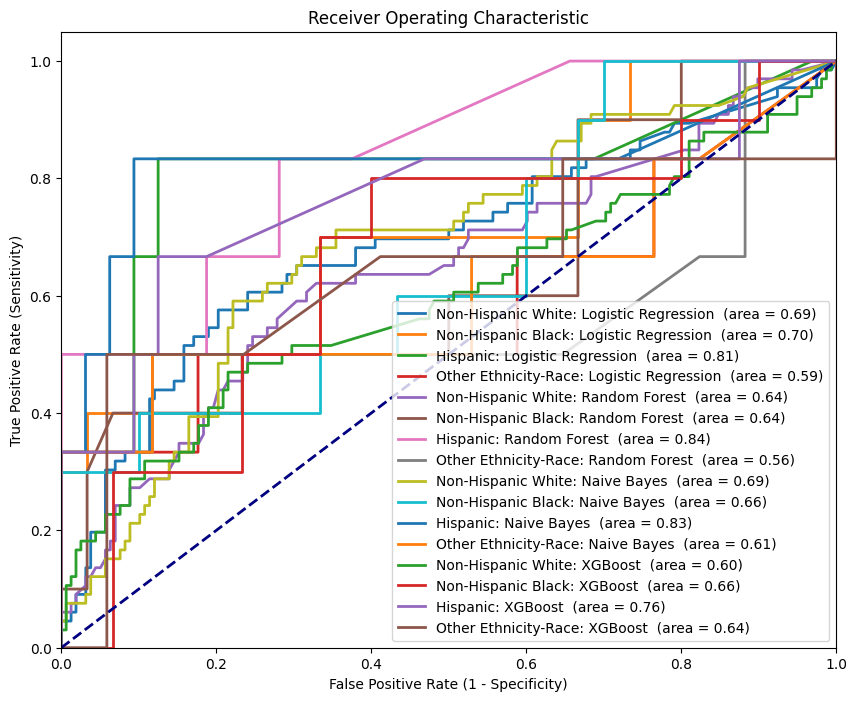

In [46]:
# Define models
models = {
    'Logistic Regression': unbal_logreg,
    'Random Forest': unbal_rf,
    'Naive Bayes': unbal_nb,
    'XGBoost': unbal_xgb,
}

# Define race-mix test sets
rm = {
    'Non-Hispanic White' : [X_test_NHWhite, y_test_NHWhite],
    'Non-Hispanic Black' : [X_test_NHBlack, y_test_NHBlack],
    'Hispanic' : [X_test_Hispanic, y_test_Hispanic],
    'Other Ethnicity-Race' : [X_test_Other, y_test_Other]
}

plt.figure(figsize=(10, 8))

# Calculate ROC curve and ROC AUC for each model
for name, model in models.items():
    for rm_name, rm_test_set in rm.items():
        probas_ = model.predict_proba(rm_test_set[0])
        fpr, tpr, thresholds = roc_curve(rm_test_set[1], probas_[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{rm_name}: {name}  (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

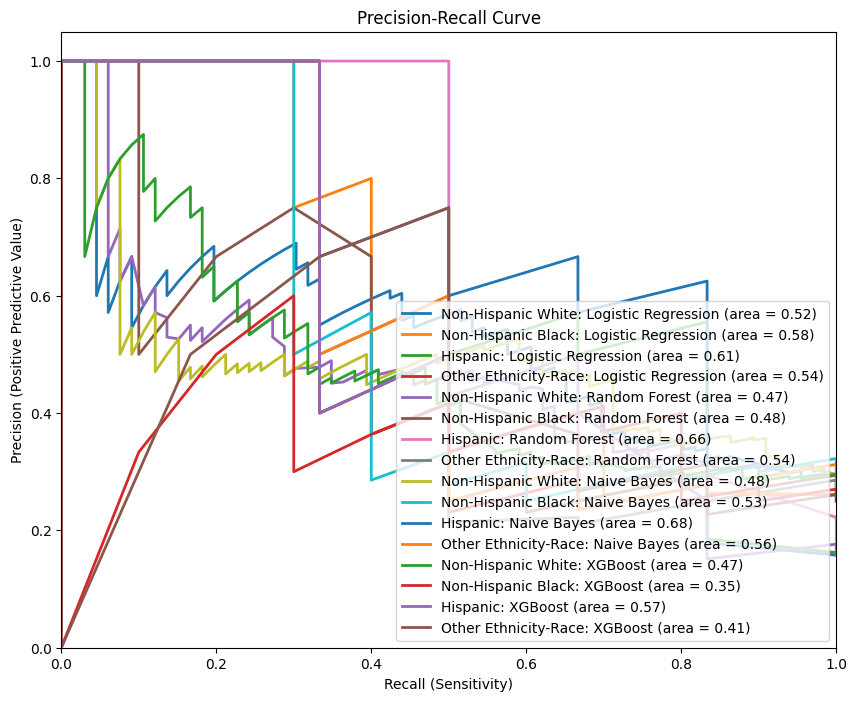

In [47]:
plt.figure(figsize=(10, 8))

# Calculate precision-recall curve and AUC for each model
for name, model in models.items():
    for rm_name, rm_test_set in rm.items():
        probas_ = model.predict_proba(rm_test_set[0])
        precision, recall, thresholds = precision_recall_curve(rm_test_set[1], probas_[:, 1])
        auprc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{rm_name}: {name} (area = {auprc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right") 
plt.show()